# Классификация изображений
### Основная идея этого решения: взять предобученую на ImageNet сеть EfficientNetB6 и дообучить под нашу задачу

В данном ноутбуке были использованы приемы, которые рассматривались в теории и практике седьмого юнита. Продвинутые библиотеки аугментации и learning rate one cycle policy использовались в другом ноутбуке: https://www.kaggle.com/fedorazarov/car-classification-fa/



# Преднастройки

Монтируем гугл-диск

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle/unit7"

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle/unit7

/content/gdrive/My Drive/Kaggle/unit7


Установка и импорт необходимых библиотек

In [ ]:
!pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [ ]:
!pip install -q efficientnet

In [ ]:
#!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

In [ ]:
!nvidia-smi

Thu Oct  1 12:42:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    31W / 250W |   8763MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn
import zipfile

#from ImageDataAugmentor.image_data_augmentor import *
#import albumentations

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("input/"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['train.csv', 'test.zip', 'train.zip', 'sample-submission.csv']
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 20  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 250 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
DATA_PATH = 'input/'
PATH = "working/car/" # рабочая директория

In [ ]:
os.makedirs(PATH,exist_ok=False)

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [ ]:
df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


In [1]:
# Закомментировал т.к. мы ранее уже распаковали картинки
# print('Пример картинок (random sample)')
# plt.figure(figsize=(12,8))

# random_image = df.sample(n=9)
# random_image_paths = random_image['Id'].values
# random_image_cat = random_image['Category'].values

# for index, path in enumerate(random_image_paths):
#     im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
#     plt.subplot(3,3, index+1)
#     plt.imshow(im)
#     plt.title('Class: '+str(random_image_cat[index]))
#     plt.axis('off')
# plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

In [ ]:
# image = PIL.Image.open(PATH+'/train/0/100380.jpg')
# imgplot = plt.imshow(image)
# plt.show()
# image.size



Как мы видим, классы указывают на модели автомобилей ВАЗ, также присутствуют Ford Focus и Volkswagen Passat


# Подготовка данных

## Аугментация данных

In [ ]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 30,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

## Генерация данных

In [ ]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Пример картинок из train_generator


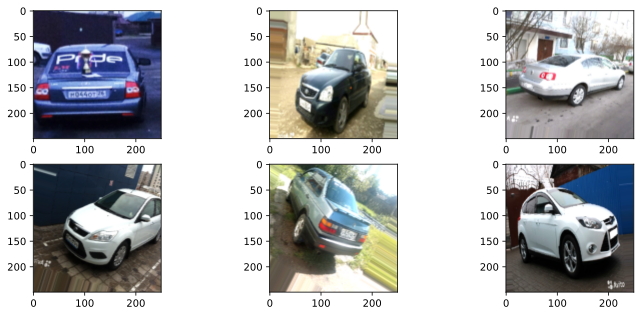

In [ ]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


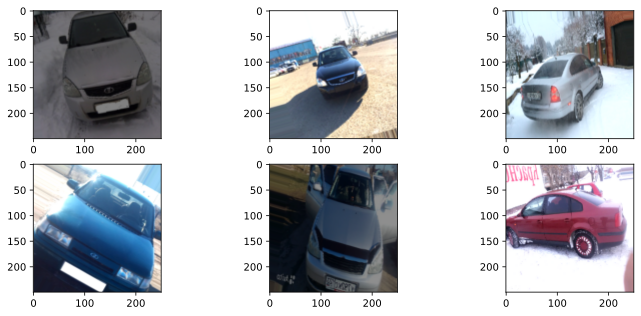

In [ ]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Построение модели

На момент выполнения задания сеть EfficientNetB6 все ещё является оптимальным выбором, если брать во внимание точность предсказаний и время работы.

In [ ]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
base_model.summary()

Model: "efficientnet-b6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 125, 125, 56) 1512        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 125, 125, 56) 224         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 125, 125, 56) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [ ]:
# Для начала заморозим веса EfficientNetB6 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model.trainable = False

Устанавливаем "голову"

In [ ]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)

# Экспериментируем с архитектурой - добавляем ещё один полносвязный слой, dropout и batch-нормализацию
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))

model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [ ]:
# Смотрим на получившуюся модель
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
____________________________________

In [ ]:
# Количество слоев
print(len(model.layers))

6


In [ ]:
# Количество параметров обучения
len(model.trainable_variables)

6

In [ ]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f2b5f55f198> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2b5ca2a4a8> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2b5ca2a470> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2b5c28a748> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2b5c28ae10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2b5c28fd30> True


# Обучение модели

## Step 1 - обучение "головы"

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
LR=0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
# scores = model.evaluate_generator(test_generator, verbose=1)
# print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 76s 195ms/step - loss: 2.3229 - accuracy: 0.0897
Accuracy: 8.97%


In [ ]:
# Обучаем
history = model.fit_generator(
                    train_generator,
                    steps_per_epoch = train_generator.samples//train_generator.batch_size,
                    validation_data = test_generator, 
                    validation_steps = test_generator.samples//test_generator.batch_size,
                    epochs = 20,
                    callbacks = callbacks_list
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1556/1556 [==============================] - ETA: 0s - loss: 1.6750 - accuracy: 0.4138
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 373s 240ms/step - loss: 1.6750 - accuracy: 0.4138 - val_loss: 1.1208 - val_accuracy: 0.5925
Epoch 2/20
1556/1556 [==============================] - ETA: 0s - loss: 1.4249 - accuracy: 0.4875
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 368s 236ms/step - loss: 1.4249 - accuracy: 0.4875 - val_loss: 1.0515 - val_accuracy: 0.6334
Epoch 3/20
1556/1556 [==============================] - ETA: 0s - loss: 1.3761 - accuracy: 0.5104
Epoch 00003: saving model to best_model.hdf5
1556/1556 [==============================] - 366s 235ms/step - loss: 1.3761 - accuracy: 0.5104 - val_loss: 0.9984 - val_accuracy: 0.6476
Epoch 4/20
1556/1556 [==============================] - ETA: 0s - loss: 1.3191 - acc

удивительно на сколько эта модель хорошо умеет извлекать признаки!

даже без дообучения получаем столь высокий Accuracy



In [ ]:
# сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
model.save('working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

## Step 2 - FineTuning - обучение половины весов EfficientNetb6

In [ ]:
# Посмотрим на количество слоев в базовой модели
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [ ]:
# Разморозим базовую модель
base_model.trainable = True

# Установим количество слоев, которые будем переобучать
fine_tune_at = len(base_model.layers)//2

# Заморозим первую половину слоев
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Количество параметров
len(base_model.trainable_variables)

291

In [ ]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f2b5f55f198> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2b5ca2a4a8> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2b5ca2a470> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2b5c28a748> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2b5c28ae10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2b5c28fd30> True


In [ ]:
LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 38,289,632
Non-trainable params: 3,264,178
__________________________________

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 76s 196ms/step - loss: 0.7834 - accuracy: 0.7189
Accuracy: 71.89%


In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
1556/1556 [==============================] - ETA: 0s - loss: 1.0437 - accuracy: 0.6406
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 417s 268ms/step - loss: 1.0437 - accuracy: 0.6406 - val_loss: 0.4006 - val_accuracy: 0.8544
Epoch 2/20
1556/1556 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.7944
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 413s 266ms/step - loss: 0.5812 - accuracy: 0.7944 - val_loss: 0.2844 - val_accuracy: 0.8956
Epoch 3/20
1556/1556 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8427
Epoch 00003: saving model to best_model.hdf5
1556/1556 [==============================] - 408s 262ms/step - loss: 0.4583 - accuracy: 0.8427 - val_loss: 0.2218 - val_accuracy: 0.9224
Epoch 4/20
1556/1556 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.8725
Epoch 00004: saving model to best_model.hdf5
1556/1556 [======

In [ ]:
model.save('working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 75s 193ms/step - loss: 0.1759 - accuracy: 0.9498
Accuracy: 94.98%


## Step 3 - FineTuning - разморозка всей сети EfficientNetB6 и дообучение

In [ ]:
# Разморозим базовую модель
base_model.trainable = True

Повторно обучим модель, предварительно разморозив все слои

In [ ]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
1556/1556 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9613
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 584s 375ms/step - loss: 0.1069 - accuracy: 0.9613 - val_loss: 0.1502 - val_accuracy: 0.9530
Epoch 2/20
1556/1556 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9717
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 581s 373ms/step - loss: 0.0854 - accuracy: 0.9717 - val_loss: 0.1351 - val_accuracy: 0.9581
Epoch 3/20
1556/1556 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9760
Epoch 00003: saving model to best_model.hdf5
1556/1556 [==============================] - 580s 373ms/step - loss: 0.0715 - accuracy: 0.9760 - val_loss: 0.1285 - val_accuracy: 0.9610
Epoch 4/20
1556/1556 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9733
Epoch 00004: saving model to best_model.hdf5
1556/1556 [======

In [ ]:
model.save('working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 74s 189ms/step - loss: 0.1459 - accuracy: 0.9598
Accuracy: 95.98%


## Step 4 - увеличение размера изображения

In [ ]:
EPOCHS               = 20
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 30,
    #shear_range=0.2,
    zoom_range=[0.75,1.25],
    #brightness_range=[0.5, 1.5],
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    validation_split=VAL_SPLIT,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Заново создаем сеть с новым размером входных данных

In [ ]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Подгружаем ранее обученные веса
model.load_weights('best_model.hdf5')

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/20
3113/3113 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8930
Epoch 00001: saving model to best_model.hdf5
3113/3113 [==============================] - 2225s 715ms/step - loss: 0.3682 - accuracy: 0.8930 - val_loss: 0.1166 - val_accuracy: 0.9694
Epoch 2/20
3113/3113 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9371
Epoch 00002: saving model to best_model.hdf5
3113/3113 [==============================] - 2216s 712ms/step - loss: 0.2110 - accuracy: 0.9371 - val_loss: 0.1076 - val_accuracy: 0.9730
Epoch 3/20
3113/3113 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9517
Epoch 00003: saving model to best_model.hdf5
3113/3113 [==============================] - 2218s 713ms/step - loss: 0.1702 - accuracy: 0.9517 - val_loss: 0.1070 - val_accuracy: 0.9759
Epoch 4/20
3113/3113 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9586
Epoch 00004: saving model to best_model.hdf5
3113/3113 [===

In [ ]:
model.save('working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

778/778 [==============================] - 205s 264ms/step - loss: 0.1002 - accuracy: 0.9720
Accuracy: 97.20%


# Предсказание на тестовых данных

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

Instructions for updating:
Please use Model.predict, which supports generators.
1669/1669 [==============================] - 188s 113ms/step


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


# Test Time Augmentation

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Аугментируем тестовые изображения и сделаем несколько предсказаний одной картинки в разном виде. Взяв среднее значение из нескольких предсказаний получим итоговое предсказание.

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 30,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
  )

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

1669/1669 [==============================] - 497s 298ms/step


In [ ]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


# Итоги

В ходе выполнения проекта были применены следующие методы:

*    transfer learning и fine-tuning
*    настройка LR, optimizer, loss
*    подобраны переменные (размер картинки, батч и т.д.)
*    SOTA архитектура сетей - EfficientNetB6
*    добавлена Batch Normalization и изменена архитектура “головы”
*    применены дополнительные функции callback Keras https://keras.io/callbacks/
*    TTA (Test Time Augmentation)

Ещё один ноутбук, в котором использовалась библиотека аугментации Albumenations и Learning rate One Cycle Policy: https://www.kaggle.com/fedorazarov/car-classification-fa